In [1]:
import os, glob, json, sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import cv2
import tqdm
from PIL import Image
import torch

In [2]:
import fastai.vision.all as faivi

In [3]:
sys.path.append('/home/users/jsoelter/Code/Covid19_network/utils/')
import data_loader

In [4]:
datapath = '/work/projects/covid19_dv/heavy_datasets/chexpert_stanford/'

In [5]:
import torchvision

preprocess_train = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(512),
    torchvision.transforms.RandomRotation(5),
    torchvision.transforms.RandomCrop((480, 480)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

In [1]:
include_meta = ['Sex', 'AP/PA', 'Frontal/Lateral']
subset = {'Consolidation': [0,1]}, # Define subsetting of data


data = data_loader.ChexpertData('CheXpert-v1.0/train.csv', transform=preprocess_train, subset=subset, include_meta = include_meta)
internal_valid_data, train_data = torch.utils.data.random_split(data, [1000, len(data)-1000], subset=subset, generator=torch.Generator().manual_seed(42))
external_valid_data = data_loader.ChexpertData('CheXpert-v1.0/valid.csv', transform=preprocess_train, subset=subset, include_meta = include_meta, fill_hierachy={})

NameError: name 'data_loader' is not defined

In [7]:
def my_loss(x, y, reduction='mean'):
    ignore_index = y >= 0
    loss = faivi.F.binary_cross_entropy_with_logits(x[ignore_index], y[ignore_index], reduction=reduction).float()
    return loss

In [8]:
data_loaders = faivi.DataLoaders.from_dsets(train_data, internal_valid_data, bs=16)
#data_loaders = faivi.DataLoaders(train_loader, valid_ext_loader)

In [24]:
learn = faivi.cnn_learner(
    data_loaders, 
    faivi.resnet50, 
    loss_func=my_loss, #faivi.F.binary_cross_entropy_with_logits, 
    #opt_func=faivi.Adam, 
    cbs=faivi.CudaCallback, 
    n_out=len(data.targets)
)#.to_fp16()

In [25]:
learn.unfreeze()

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=1.5848931980144698e-06)

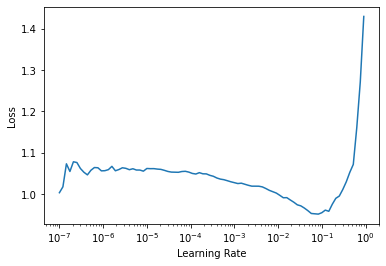

In [26]:
learn.lr_find()

In [ ]:
#learn.model = torch.nn.DataParallel(learn.model)

In [ ]:
learn.fit_one_cycle(5, lr_max=0.02)

epoch,train_loss,valid_loss,time


IndexError: list index out of range

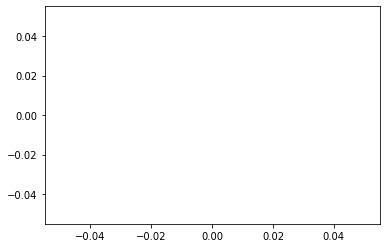

In [39]:
learn.recorder.plot_loss(skip_start=0)
#plt.ylim((0.25, 0.5))

In [ ]:
p = '/home/users/jsoelter/models/Resnet151/v1'
os.makedirs(os.path.basename(p))
learn.save(p)

In [34]:
interp = faivi.ClassificationInterpretation.from_learner(learn)

TypeError: from_learner() got an unexpected keyword argument 'with_loss'

In [36]:
len(internal_valid_data)

1000

In [45]:
learn.x.shape

torch.Size([16, 3, 480, 480])

In [46]:
learn.y.shape

torch.Size([16, 16])